In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from copy import deepcopy
import pickle as pkl

from ex_cosmology import p
from matplotlib import gridspec
import seaborn as sns
import matplotlib.patches as mpatches

# adaptive-wavelets modules
import awave
from awave.data.cosmology import get_dataloader, load_pretrained_model
from awave.data.cosmology import get_validation
from awave.utils.misc import tuple_to_tensor
from awave.trim import TrimModel
from umap import UMAP
from sklearn.decomposition import PCA
import seaborn
import pandas as pd

# evaluation
from eval_cosmology import load_results, rmse_bootstrap, extract_patches
from peak_counting import PeakCount

In [2]:
dirs = [
    "db5_saliency_warmstart_seed=1_new"
]
dics, results, models = load_results(dirs)

In [3]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path,
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size)

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)

# validation dataset
test_loader = get_validation(p.data_path,
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

# Optimal wavelet

In [4]:
# # DB5
wt_o = awave.DWT2d(wave='db5', mode='zero', J=4,
                               init_factor=1, noise_factor=0, const_factor=0)

# load optimal wavelet for prediction on heldout dataset
bds = np.linspace(0.015, 0.035, 5)
scores = pkl.load(open('results/scores_new.pkl', 'rb'))
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dics[0]['wt'].keys())[col + 1]  ## NEED TO CHECK
# idx2 = 4
wt = dics[0]['wt'][(idx1, idx2)].to('cpu')

In [5]:
X1_batch = []
X2_batch = []
y_test = []
for x,y in test_loader:
    X1_batch.append(wt(x))
    X2_batch.append(wt_o(x))
    y_test.append(y)
    
X1 = tuple()
X2 = tuple()
for idx in range(5):
    a = [x[idx] for x in X1_batch]
    X1 += (torch.cat(a, dim=0),)
    b = [x[idx] for x in X2_batch]
    X2 += (torch.cat(b, dim=0),)
y_test = torch.cat([a[:,1] for a in y_test], dim=0)

# pca
pca = PCA(n_components=6)

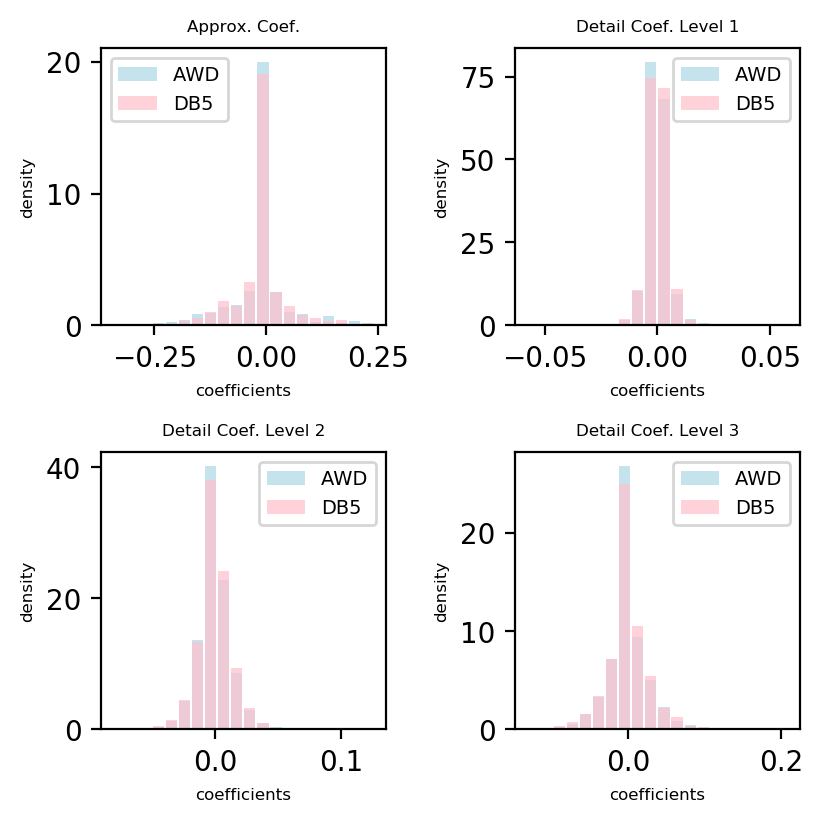

In [21]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['red', 'lightblue']
n = 2000
np.random.seed(3)
random_index = np.random.randint(0, n)
coefs1 = [x[random_index].detach().cpu().numpy().squeeze().reshape(-1) for x in X1]
coefs2 = [x[random_index].detach().cpu().numpy().squeeze().reshape(-1) for x in X2]

# embedding1 vs embedding2
f_ax1 = fig.add_subplot(spec[0, 0])

_, bins, _ = plt.hist(coefs1[0], bins=20, color='lightblue', alpha=0.7, rwidth=0.85, normed=True, label='AWD')
_ = plt.hist(coefs2[0], bins=bins, color='pink', alpha=0.7, rwidth=0.85, density=True, label='DB5')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(prop={'size': 7})
plt.title("Approx. Coef.", fontsize=6)
plt.xlabel('coefficients', fontsize=6)
plt.ylabel('density', fontsize=6)

# embedding1 vs embedding2
f_ax2 = fig.add_subplot(spec[0, 1])

_, bins, _ = plt.hist(coefs1[1], bins=20, color='lightblue', alpha=0.7, rwidth=0.85, normed=True, label='AWD')
_ = plt.hist(coefs2[1], bins=bins, color='pink', alpha=0.7, rwidth=0.85, density=True, label='DB5')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(prop={'size': 7})
plt.title("Detail Coef. Level 1", fontsize=6)
plt.xlabel('coefficients', fontsize=6)
plt.ylabel('density', fontsize=6)

# embedding1 vs embedding2
f_ax3 = fig.add_subplot(spec[1, 0])

_, bins, _ = plt.hist(coefs1[2], bins=20, color='lightblue', alpha=0.7, rwidth=0.85, normed=True, label='AWD')
_ = plt.hist(coefs2[2], bins=bins, color='pink', alpha=0.7, rwidth=0.85, density=True, label='DB5')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(prop={'size': 7})
plt.title("Detail Coef. Level 2", fontsize=6)
plt.xlabel('coefficients', fontsize=6)
plt.ylabel('density', fontsize=6)

# embedding1 vs embedding2
f_ax4 = fig.add_subplot(spec[1, 1])

_, bins, _ = plt.hist(coefs1[3], bins=20, color='lightblue', alpha=0.7, rwidth=0.85, normed=True, label='AWD')
_ = plt.hist(coefs2[3], bins=bins, color='pink', alpha=0.7, rwidth=0.85, density=True, label='DB5')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(prop={'size': 7})
plt.title("Detail Coef. Level 3", fontsize=6)
plt.xlabel('coefficients', fontsize=6)
plt.ylabel('density', fontsize=6)

plt.show()

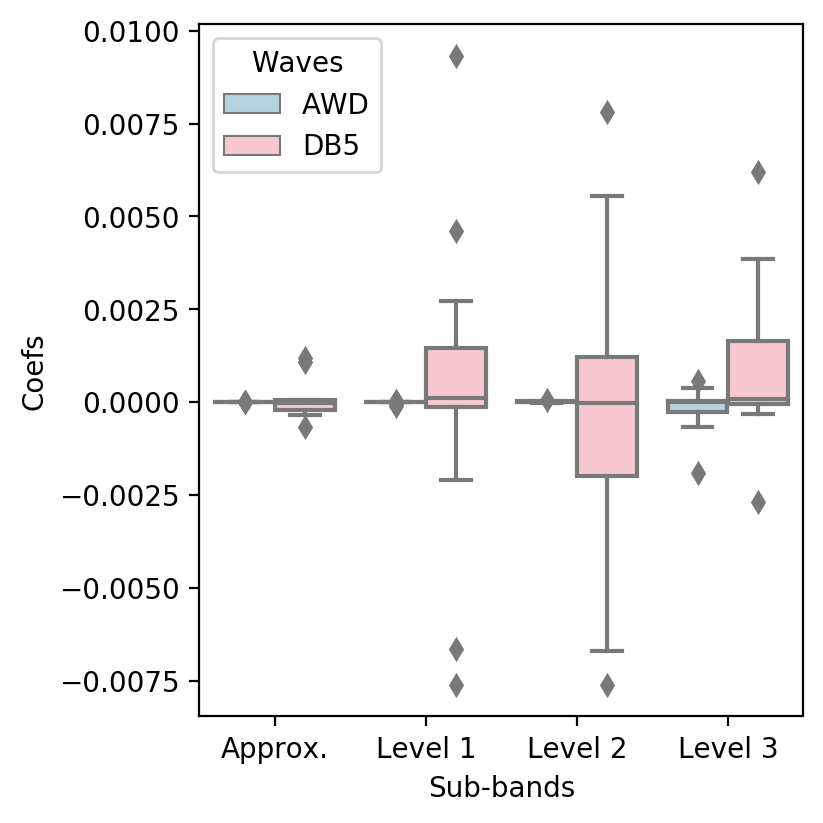

In [24]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

f_ax1 = fig.add_subplot(spec[0, 0])

all_coefs = coefs1[:4] + coefs2[:4]
all_coefs = list(np.concatenate(all_coefs))
labels = ["Approx."]*10 + ["Level 1"]*24 + ["Level 2"]*16 + ["Level 3"]*12
labels = labels + labels
waves = ["AWD"]*62 + ["DB5"]*62

df = pd.DataFrame(list(zip(all_coefs, labels, waves)), columns =['Coefs', 'Sub-bands', 'Waves'])
ax = sns.boxplot(x="Sub-bands", y="Coefs", hue="Waves", data=df, palette=['lightblue', 'pink'])
plt.show()